In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def averagingFilter(data, n):
    out = np.zeros(shape=(len(data), ))
    for i in range(len(data)-n):
        for j in range(n):
            out[i] += data[i+j]/n

# What to add?
* bistatic geometry (Tx, Rx positions)
* RD ambiuguity - take into acconut offset in range cused by doppler frequency
* fit both range and velocity
* regularization - kinda kalman like, correlation thing

In [159]:
def generateLinearTrajectory(t, x0 = 100, vy = 100, y=0, h = 20, sigma2 = 0):
    return np.sqrt(x0**2+((vy*t)+y)**2+h**2) + sigma2*np.random.randn(len(t))

def generateLinearXYZ(t, x0 = 100, vy = 100, y=0, h = 20, sigma2 = 0):
    return np.ones(shape=(len(t)))*x0, ((vy*t)+y), np.ones(shape=(len(t)))*h

def generateLinearVelocityTrajectory(t, x0 = 100, vx=1, vy = 100, y=0, h = 20, vh=2, sigma2 = 0):
    return np.sqrt(((vx*t)+x0)**2+((vy*t)+y)**2+((vh*t)+h)**2) + sigma2*np.random.randn(len(t))

def generateLinearVelocityXYZ(t, x0 = 100, vx=1, vy = 100, y=0, h = 20, vh=2, sigma2 = 0):
    return ((vx*t)+x0), ((vy*t)+y), ((vh*t)+h)

def SSE(y_true, y_hat):
    return sum(y_true - y_hat)**2

class history:
    def __init__(self):
        self.x = []
        self.y = []
        self.h = []
        self.loss = []        

class channel:
    def __init__(self, recordedTrajectory, t, x=0, y=0, z=0):
        # position
        self.x = x
        self.y = y
        self.z = z
        self.t = t
        self.recordedTrajectory = recordedTrajectory

class RangeModel:
    def __init__(self, len, lr = 0.0001):
        # initiallizae
        self.x = np.ones(shape=(len,))
        self.y = np.ones(shape=(len,))
        self.h = np.ones(shape=(len,))
        self.lr = lr

    def f(self, x, xn, y, yn, h, hn):
        return np.sqrt((x+xn)**2 + (y+yn)**2 + (h+hn)**2)

    def dSE_by_dx(self, y_true, y_hat, x, xn, y, yn, h, hn):
        return (2*(x+xn) * (y_true-y_hat)) / self.f(x, xn, y, yn, h, hn)

    def dSE_by_dy(self, y_true, y_hat, x, xn, y, yn, h, hn):
        return (2*(y+yn) * (y_true-y_hat)) / self.f(x, xn, y, yn, h, hn)

    def dSE_by_dh(self, y_true, y_hat, x, xn, y, yn, h, hn):
        return (2*(h+hn) * (y_true-y_hat)) / self.f(x, xn, y, yn, h, hn)

    def fit(self, channels, iterations):
        fithistory = history()
        t = channels[0].t # can times here be different?

        for _ in range(iterations):
            for j in range(len(channels)):
                channel = channels[j]
                y_hat = self.f(self.x, channel.x, self.y, channel.y, self.h, channel.z)
                self.x += self.lr*self.dSE_by_dx(channel.recordedTrajectory, y_hat, self.x, channel.x, self.y, channel.y, self.h, channel.z)
                self.y += self.lr*self.dSE_by_dy(channel.recordedTrajectory, y_hat, self.x, channel.x, self.y, channel.y, self.h, channel.z)
                self.h += self.lr*self.dSE_by_dh(channel.recordedTrajectory, y_hat, self.x, channel.x, self.y, channel.y, self.h, channel.z)
            fithistory.x.append(self.x.copy())
            fithistory.y.append(self.y.copy())
            fithistory.h.append(self.h.copy())
            fithistory.loss.append(SSE(y_hat, channel.recordedTrajectory)) # this is not true, but is close enough
        return fithistory

# Linear trajectory

how it learns?

In [137]:
# time
t = np.arange(-1,1,1e-2)

# movement parmeters (what we'll be fittting)
x0 = 100
vy = 100
h = 20
sigma = 0


# channel position
x = 0
y = 0
z = 0
ch1 = channel(generateLinearTrajectory(t, x0+x, vy, y, h+z, sigma2=sigma), t, x, y, z)

# channel position
x = 0
y = 0
z = 10
ch2 = channel(generateLinearTrajectory(t, x0+x, vy, y, h+z, sigma2=sigma), t, x, y, z)

# channel position
x = 0
y = 100
z = 0
ch3 = channel(generateLinearTrajectory(t, x0+x, vy, y, h+z, sigma2=sigma), t, x, y, z)

# model
model = RangeModel(lr=0.01, len = len(ch1.recordedTrajectory))
fithistory = model.fit([ch1, ch2, ch3], 100000)

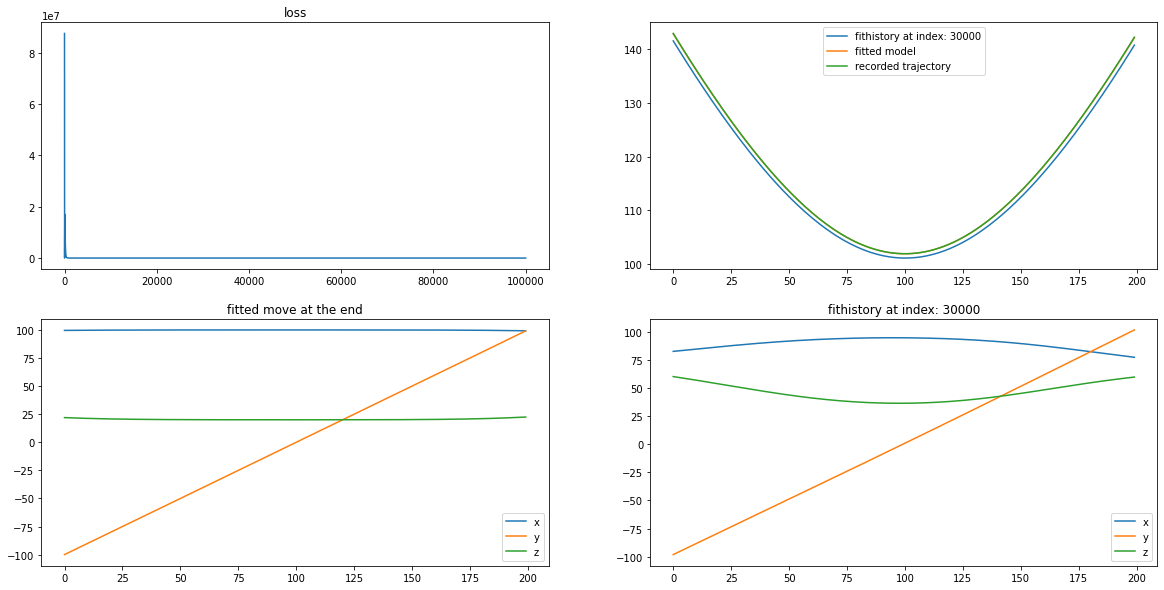

In [138]:
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.plot(fithistory.loss)
plt.title('loss')

index = 30000
plt.subplot(2,2,2)
plt.plot(np.sqrt(fithistory.h[index]**2+fithistory.x[index]**2+fithistory.y[index]**2))
plt.plot(np.sqrt(model.h**2+model.x**2+model.y**2))
plt.plot(ch1.recordedTrajectory)
plt.legend([f"fithistory at index: {index}", 'fitted model','recorded trajectory'])

plt.subplot(2,2,3)
plt.plot(model.x)
plt.plot(model.y)
plt.plot(model.h)
plt.title('fitted move at the end')
plt.legend(['x','y','z'])

plt.subplot(2,2,4)
plt.plot(fithistory.x[index])
plt.plot(fithistory.y[index])
plt.plot(fithistory.h[index])
plt.legend(['x','y','z'])
plt.title(f"fithistory at index: {index}")
plt.show()

how nice it looks compared to trajectory

In [155]:
# time
t = np.arange(-1,1,1e-2)

# movement parmeters (what we'll be fittting)
x0 = 100
vy = 100
h = 20
sigma = 0


# channel position
x = 0
y = 0
z = 0
ch1 = channel(generateLinearTrajectory(t, x0+x, vy, y, h+z, sigma2=sigma), t, x, y, z)

# channel position
x = 0
y = 0
z = 10
ch2 = channel(generateLinearTrajectory(t, x0+x, vy, y, h+z, sigma2=sigma), t, x, y, z)

# channel position
x = 0
y = 100
z = 0
ch3 = channel(generateLinearTrajectory(t, x0+x, vy, y, h+z, sigma2=sigma), t, x, y, z)

# model
model = RangeModel(lr=0.01, len = len(ch1.recordedTrajectory))
fithistory = model.fit([ch1, ch2, ch3], 100000)

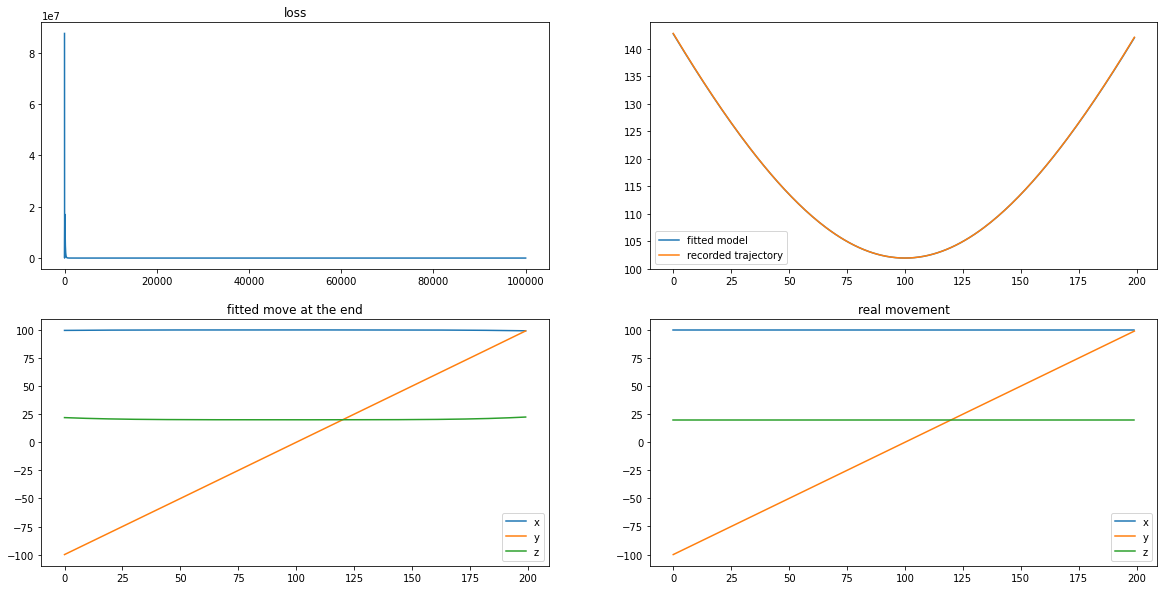

In [161]:
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.plot(fithistory.loss)
plt.title('loss')

plt.subplot(2,2,2)
plt.plot(np.sqrt(model.h**2+model.x**2+model.y**2))
plt.plot(ch1.recordedTrajectory)
plt.legend(['fitted model','recorded trajectory'])

plt.subplot(2,2,3)
plt.plot(model.x)
plt.plot(model.y)
plt.plot(model.h)
plt.title('fitted move at the end')
plt.legend(['x','y','z'])

plt.subplot(2,2,4)
x,y,z = generateLinearXYZ(t, x0, vy, 0, h, sigma2=sigma)
plt.plot(x)
plt.plot(y)
plt.plot(z)
plt.legend(['x','y','z'])
plt.title('real movement')
plt.show()

In [164]:
# time
t = np.arange(-1,1,1e-2)

# movement parmeters (what we'll be fittting)
x0 = 100
vy = 100
h = 20
sigma = 0


# channel position
x = 0
y = 0
z = 0
ch1 = channel(generateLinearTrajectory(t, x0+x, vy, y, h+z, sigma2=sigma), t, x, y, z)

# channel position
x = 0
y = 0
z = 10
ch2 = channel(generateLinearTrajectory(t, x0+x, vy, y, h+z, sigma2=sigma), t, x, y, z)

# channel position
x = 0
y = 0
z = 30
ch3 = channel(generateLinearTrajectory(t, x0+x, vy, y, h+z, sigma2=sigma), t, x, y, z)

# model
model = RangeModel(lr=0.01, len = len(ch1.recordedTrajectory))
fithistory = model.fit([ch1, ch2, ch3], 100000)

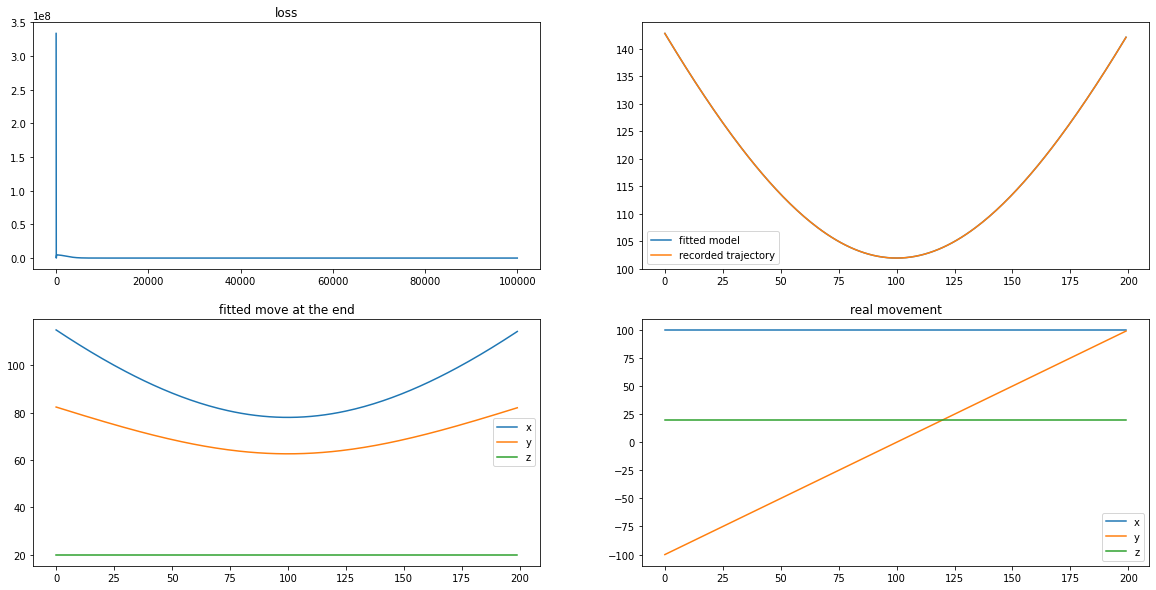

In [165]:
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.plot(fithistory.loss)
plt.title('loss')

plt.subplot(2,2,2)
plt.plot(np.sqrt(model.h**2+model.x**2+model.y**2))
plt.plot(ch1.recordedTrajectory)
plt.legend(['fitted model','recorded trajectory'])

plt.subplot(2,2,3)
plt.plot(model.x)
plt.plot(model.y)
plt.plot(model.h)
plt.title('fitted move at the end')
plt.legend(['x','y','z'])

plt.subplot(2,2,4)
x,y,z = generateLinearXYZ(t, x0, vy, 0, h, sigma2=sigma)
plt.plot(x)
plt.plot(y)
plt.plot(z)
plt.legend(['x','y','z'])
plt.title('real movement')
plt.show()

how it works with noise?

In [167]:
# time
t = np.arange(-1,1,1e-2)

# movement parmeters (what we'll be fittting)
x0 = 100
vy = 100
h = 20
sigma = 1


# channel position
x = 0
y = 0
z = 0
ch1 = channel(generateLinearTrajectory(t, x0+x, vy, y, h+z, sigma2=sigma), t, x, y, z)

# channel position
x = 0
y = 0
z = 10
ch2 = channel(generateLinearTrajectory(t, x0+x, vy, y, h+z, sigma2=sigma), t, x, y, z)

# channel position
x = 0
y = 100
z = 0
ch3 = channel(generateLinearTrajectory(t, x0+x, vy, y, h+z, sigma2=sigma), t, x, y, z)

# model
model = RangeModel(lr=0.01, len = len(ch1.recordedTrajectory))
fithistory = model.fit([ch1, ch2, ch3], 100000)

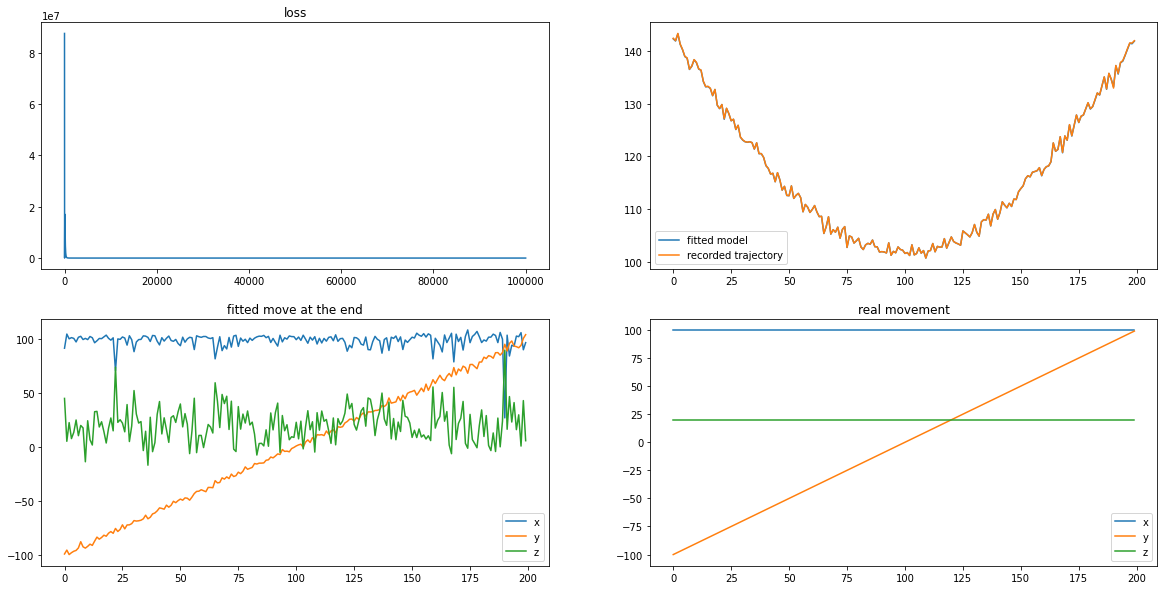

In [168]:
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.plot(fithistory.loss)
plt.title('loss')

plt.subplot(2,2,2)
plt.plot(np.sqrt(model.h**2+model.x**2+model.y**2))
plt.plot(ch1.recordedTrajectory)
plt.legend(['fitted model','recorded trajectory'])

plt.subplot(2,2,3)
plt.plot(model.x)
plt.plot(model.y)
plt.plot(model.h)
plt.title('fitted move at the end')
plt.legend(['x','y','z'])

plt.subplot(2,2,4)
x,y,z = generateLinearXYZ(t, x0, vy, 0, h, sigma2=sigma)
plt.plot(x)
plt.plot(y)
plt.plot(z)
plt.legend(['x','y','z'])
plt.title('real movement')
plt.show()

# linear speed

In [141]:
# time
t = np.arange(-1,1,1e-2)

# movement parmeters (what we'll be fittting)
x0 = 100
vx = 5
y = 0
vy = 100
h = 20
vh = 2
sigma = 0
x,y,z = generateLinearVelocityXYZ(t, x0, vx, vy, y, h, vh, sigma2 = 0)


# channel position
x = 0
y = 0
z = 0
ch1 = channel(generateLinearVelocityTrajectory(t, x0, vx, vy, y, h, vh, sigma2 = 0), t, x, y, z)

# channel position
x = 0
y = 0
z = 10
ch2 = channel(generateLinearVelocityTrajectory(t, x0, vx, vy, y, h, vh, sigma2 = 0), t, x, y, z)

# channel position
x = 0
y = 100
z = 0
ch3 = channel(generateLinearVelocityTrajectory(t, x0, vx, vy, y, h, vh, sigma2 = 0), t, x, y, z)

# model
model = RangeModel(lr=0.01, len = len(ch1.recordedTrajectory))
fithistory = model.fit([ch1, ch2, ch3], 100000)

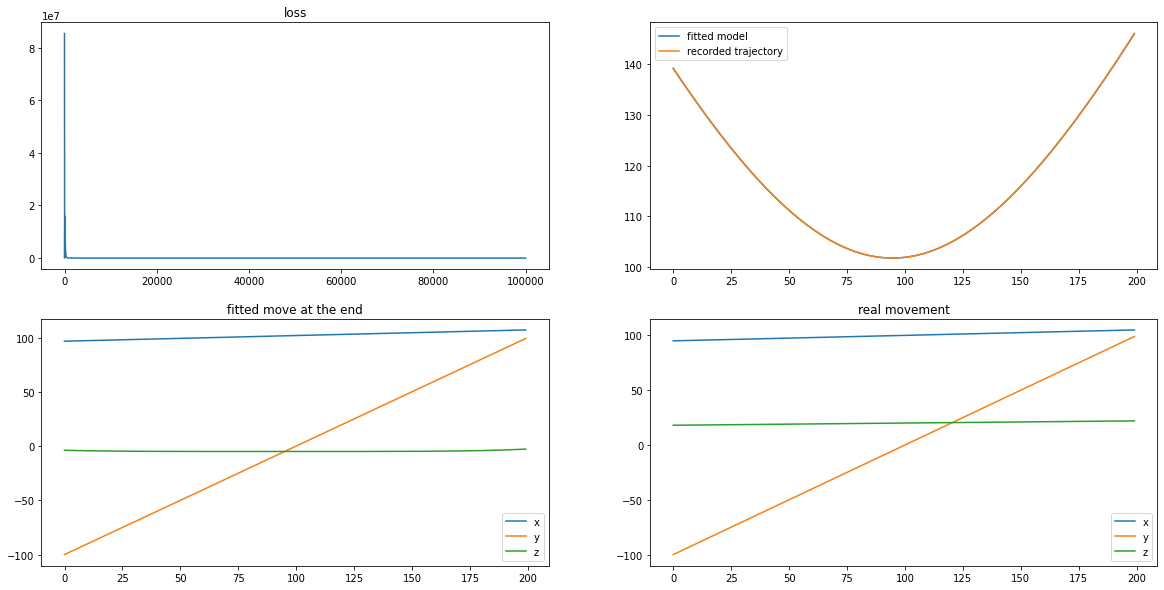

In [153]:
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.plot(fithistory.loss)
plt.title('loss')

plt.subplot(2,2,2)
plt.plot(np.sqrt(model.h**2+model.x**2+model.y**2))
plt.plot(ch1.recordedTrajectory)
plt.legend(['fitted model','recorded trajectory'])

plt.subplot(2,2,3)
plt.plot(model.x)
plt.plot(model.y)
plt.plot(model.h)
plt.title('fitted move at the end')
plt.legend(['x','y','z'])

plt.subplot(2,2,4)
plt.plot(x)
plt.plot(y-100)
plt.plot(z)
plt.legend(['x','y','z'])
plt.title('real movement')
plt.show()